In [1]:
import os
import torch
import numpy as np

from models.solver import Trainer
from data.dataloader import dataloader_info
from utils.utils import load_yaml_config, instantiate_from_config
from utils.visualize import visualization


/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
configs = load_yaml_config("configs/sine.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataloader
dl_info = dataloader_info(configs)

Sampling sine-dataset: 100%|██████████| 10000/10000 [00:00<00:00, 16043.55it/s]


In [4]:
# model
model = instantiate_from_config(configs['model']).to(device)

In [5]:
# train
trainer = Trainer(config=configs, model=model, dataloader=dl_info["dataloader"])
trainer.train()

  0%|          | 0/12000 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
loss: 0.094134: 100%|██████████| 12000/12000 [02:32<00:00, 78.93it/s] 


In [6]:
# generate multivariate time-series
dataset = dl_info['dataset']
fake_data = model.generate_mts(batch_size=len(dataset))
np.save(os.path.join(dataset.dir, f'ddpm_fake_sine.npy'), fake_data)

reverse step from x_T to x_0:   0%|          | 0/500 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
reverse step from x_T to x_0: 100%|██████████| 500/500 [00:58<00:00,  8.55it/s]


In [7]:
# load original data
seq_length, feature_dim = dataset.window, dataset.feature_dim
ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))

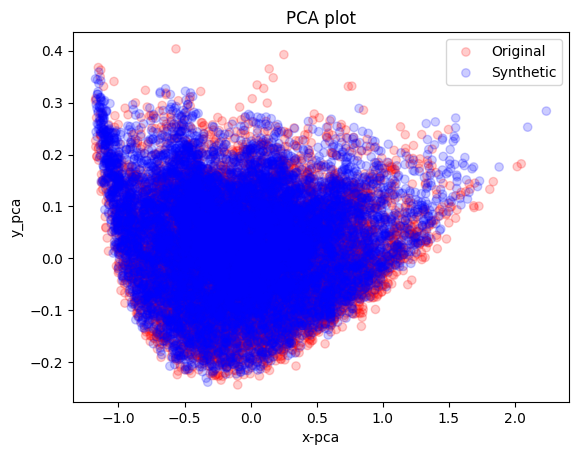

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.000s...
[t-SNE] Computed neighbors for 20000 samples in 0.281s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

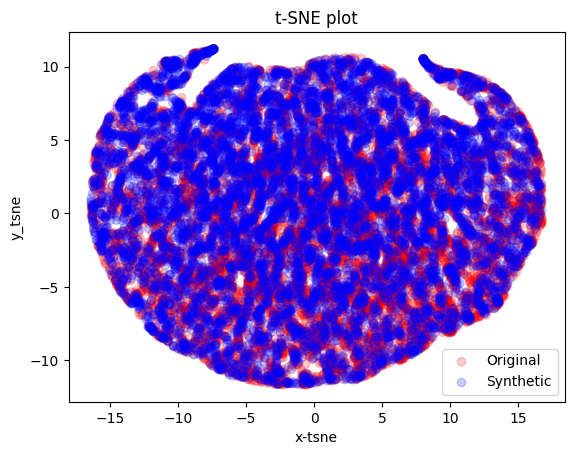

/home/harim/Desktop/pyproject/Project_TS_Generation/utils/metrics.py:93: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plt.ylabel('Data Density Estimate')
/home/harim/Desktop/pyproject/Project_TS_Generation/utils/metrics.py:94: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # plt.rcParams['pdf.fonttype']

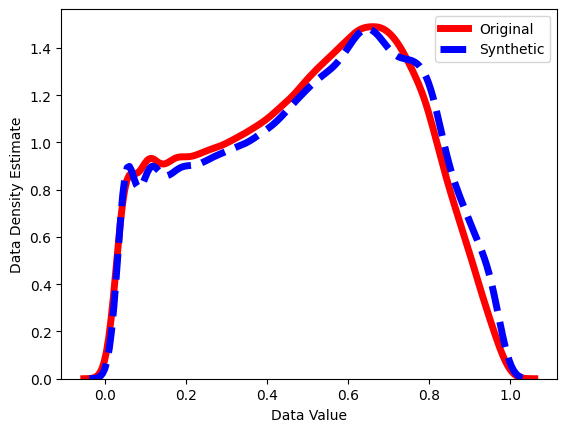

In [8]:
# visualization
visualization(ori_data=ori_data, generated_data=fake_data, analysis='pca', compare=ori_data.shape[0])
visualization(ori_data=ori_data, generated_data=fake_data, analysis='tsne', compare=ori_data.shape[0])
visualization(ori_data=ori_data, generated_data=fake_data, analysis='kernel', compare=ori_data.shape[0])

In [9]:
# quantatitive metrics
# cross correlation score

from metrics.cross_correlation import CrossCorrelLoss
from utils.utils import display_scores

iterations = 5
ori_data = np.load(os.path.join(dataset.dir, f"sine_ground_truth_{seq_length}_train.npy"))
fake_data = np.load(os.path.join(dataset.dir, f"ddpm_fake_sine.npy"))

In [10]:
def random_choice(size, num_select=100):
    select_idx = np.random.randint(low=0, high=size, size=(num_select,))
    return select_idx

In [11]:
x_real = torch.from_numpy(ori_data)
x_fake = torch.from_numpy(fake_data)

correlational_score = []
size = int(x_real.shape[0] / iterations)

for i in range(iterations):
    real_idx = random_choice(x_real.shape[0], size)
    fake_idx = random_choice(x_fake.shape[0], size)
    corr = CrossCorrelLoss(x_real[real_idx, :, :], name='CrossCorrelLoss')
    loss = corr.compute(x_fake[fake_idx, :, :])
    correlational_score.append(loss.item())
    print(f'Iter {i}: ', 'cross-correlation =', loss.item(), '\n')

display_scores(correlational_score)

Iter 0:  cross-correlation = 0.03939898684620857 

Iter 1:  cross-correlation = 0.04752101004123688 

Iter 2:  cross-correlation = 0.049087271094322205 

Iter 3:  cross-correlation = 0.047652050852775574 

Iter 4:  cross-correlation = 0.04390552639961243 

Final Score: 0.04551 ± 0.00486
